# Project: Monthly Armed Robberies in Boston

Zaman serisi tahmini bir süreçtir ve iyi tahminler almanın tek yolu bu süreci uygulamaktır. Bu yazıda, Python ile Boston'daki aylık silahlı soygun sayısını nasıl tahmin edeceğinizi keşfedeceksiniz. Bu eğitimde çalışmak, kendi zaman serisi tahmin sorunlarınız üzerinde çalışmak için adımlar ve araçlar için bir çerçeve sağlayacaktır

Bu derste, uçtan uca, veri kümesini indirmekten ve sorunu tanımlamaktan nihai bir modeli eğitmeye ve tahminler yapmaya kadar bir zaman serisi tahmini projesi üzerinde çalışacağız. Bu proje kapsamlı değildir, ancak problemi sistematik olarak tahmin eden bir zaman serisi tahminiyle nasıl hızlı bir şekilde iyi sonuçlar alabileceğinizi gösterir. Bu projenin üzerinde çalışacağımız adımlar aşağıdaki gibidir:
1. Sorun Açıklaması
2. Test Donanımı.
3. Persistence
4. Veri analizi
5. ARIMA Models
6. Model geçerliliği ,Bu, kendi veri kümenizde kullanabileceğiniz bir zaman serisi tahmin problemi üzerinde çalışmak için bir şablon sağlayacaktır.

## Problem Description

Sorun, ABD'nin Boston kentindeki aylık silahlı soygun sayısını tahmin etmektir. Veri seti, Ocak 1966'dan Ekim 1975'e kadar veya 10 yıldan biraz daha az bir süredir Boston'daki aylık silahlı soygun sayısını sağlar. Değerler bir sayıdır ve 118 gözlem vardır. Veri kümesi McCleary ve Hay (1980) 'e yatırılmıştır. Aşağıda, veri kümesinin ilk birkaç satırının bir örneği verilmiştir.

In [3]:
import pandas as pd
series = pd.read_csv('robbery.csv',sep=";", header=0, index_col=0, parse_dates=True, squeeze=True)
series.head()

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Robberies, dtype: int64

In [8]:
series = pd.Series(series)
series.describe()

count    118.000000
mean     196.288136
std      128.043602
min       29.000000
25%       85.500000
50%      166.000000
75%      296.750000
max      500.000000
Name: Robberies, dtype: float64

## Test Donanımı 
Verileri araştırmak ve aday modelleri değerlendirmek için bir test bandı geliştirmeliyiz. Bu iki adımdan oluşur:
1. Doğrulama Veri Kümesi Tanımlama
2. Model Değerlendirme Yöntemi Geliştirmek.


## Validation Dataset
Veri kümesi güncel değil. Bu, modeli doğrulamak için güncellenmiş verileri kolayca toplayamayacağımız anlamına gelir. Bu nedenle, Ekim 1974 olduğunu iddia edeceğiz ve analiz ve model seçiminden son bir yıllık verileri saklayacağız. Bu son veri yılı, son modeli doğrulamak için kullanılacaktır. 

In [10]:
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 106, Validation 12


## Model Evaluation
Model değerlendirmesi yalnızca önceki bölümde hazırlanan dataset.csv dosyasındaki veriler üzerinde yapılacaktır. Model değerlendirme iki unsurdan oluşur:
* Performance Measure.
* Test Strategy.


## Performance Measure
Tahminlerin performansını kök ortalama kare hatası (RMSE) kullanarak değerlendireceğiz. Bu, oldukça yanlış olan ve orijinal verilerle aynı birimlere sahip olacak tahminlere daha fazla ağırlık verecektir. Farklı yöntemler arasındaki performansı doğrudan karşılaştırılabilir hale getirmek için RMSE hesaplanmadan ve raporlanmadan önce verilere yapılan tüm dönüşümler tersine çevrilmelidir.

## Test Strategy
Aday modeller ileriye doğru doğrulama kullanılarak değerlendirilecektir. Bunun nedeni, problem tanımından bir yuvarlanma tahmini türü modelinin gerekli olmasıdır. Bu, mevcut tüm veriler göz önüne alındığında tek adımlı tahminlerin gerektiği yerdir. İleri doğrulama aşağıdaki gibi çalışacaktır:
1. Veri setinin ilk% 50'si modeli eğitmek için geri tutulacaktır.
2. Veri kümesinin kalan% 50'si yinelenir ve modeli test eder.
3. Test veri kümesindeki her adım için:
(a) Bir model eğitilecektir.
(b) Tek adımlı bir tahmin ve tahmin daha sonra değerlendirilmek üzere saklanır.
(c) Test veri kümesinden gerçek gözlem, bir sonraki yineleme için eğitim veri kümesine eklenecektir.
4. Test veri kümesinin tekrarlanması sırasında yapılan tahminler değerlendirilecek ve bir RMSE puanı rapor edilecektir.
* Verilerin küçük boyutu göz önüne alındığında, her tahmin öncesinde mevcut tüm veriler göz önüne alındığında bir modelin yeniden eğitilmesine izin vereceğiz. Test koşumunun kodunu basit NumPy ve Python kodlarını kullanarak yazabiliriz. İlk olarak, veri setini doğrudan tren ve test setlerine bölebiliriz. Yüklenen verilerin hala bazı String veya Integer veri türlerine sahip olması durumunda yüklü bir veri kümesini float32'ye dönüştürmeye özen gösteririz.



In [11]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

## Persistence
Veri analizi ve modellemesinde bataklığa düşmeden önceki ilk adım, performansın temelini oluşturmaktır. Bu, hem önerilen test kayışını kullanarak modelleri değerlendirmek için hem de daha ayrıntılı tahmin modellerinin karşılaştırılabileceği bir performans ölçüsü için bir şablon sağlayacaktır. Zaman serisi tahmini için temel tahmin naif tahmin veya kalıcılık olarak adlandırılır. Bu, bir önceki zaman adımındaki gözlemin, bir sonraki zaman adımındaki gözlem için tahmin olarak kullanıldığı yerdir. Bunu doğrudan önceki bölümde tanımlanan test cihazına bağlayabiliriz. Kod listesinin tamamı aşağıda verilmiştir.

In [14]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
# predict
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=98.000, Expected=125.000
>Predicted=125.000, Expected=155.000
>Predicted=155.000, Expected=190.000
>Predicted=190.000, Expected=236.000
>Predicted=236.000, Expected=189.000
>Predicted=189.000, Expected=174.000
>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>P

## Veri analizi
Tahmin probleminin yapısı hakkında hızlı bir şekilde daha fazla bilgi edinmek için özet istatistikleri ve verilerin grafiklerini kullanabiliriz. Bu bölümde, verilere dört açıdan bakacağız:
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.

## Summary Statistics
Özet istatistikler, gözlenen değerlerin sınırlarına hızlı bir bakış sağlar. Ne ile çalıştığımız hakkında hızlı bir fikir edinmemize yardımcı olabilir. Aşağıdaki örnek, zaman serileri için özet istatistikleri hesaplar ve yazdırır.

In [15]:
# summary statistics of time series
from pandas import read_csv
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
print(series.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


## Line Plot


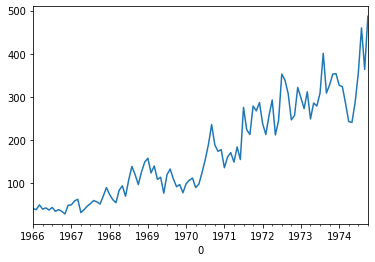

In [16]:
# line plots of time series
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
series.plot()

Some observations from the plot include:
* Soygunların zamanla artan bir eğilimi vardır.
* Belirgin bir aykırı değer yok gibi görünüyor.
* Yıldan yıla, yukarı ve aşağı nispeten büyük dalgalanmalar vardır
* Daha sonraki yıllardaki dalgalanmalar, önceki yıllardaki dalgalanmalardan daha büyük görünmektedir.
* Trend, veri kümesinin neredeyse kesinlikle sabit olmadığı ve dalgalanmadaki belirgin değişikliklerin de katkıda bulunabileceği anlamına gelir.

Bu basit gözlemler, eğilimi modellemede ve zaman serisinden çıkarmada fayda görebileceğimizi düşündürmektedir. Alternatif olarak, seriyi modelleme için sabit hale getirmek için farklılaştırma kullanabiliriz. İlerleyen yıllarda dalgalanmalarda bir büyüme eğilimi varsa iki farklılaşma seviyesine bile ihtiyacımız olabilir.

## Density Plot
Gözlem yoğunluğunun çizimlerinin gözden geçirilmesi, verilerin yapısı hakkında daha fazla bilgi sağlayabilir. Aşağıdaki örnek, herhangi bir zamansal yapı olmaksızın gözlemlerin bir histogramını ve yoğunluk grafiğini oluşturmaktadır.

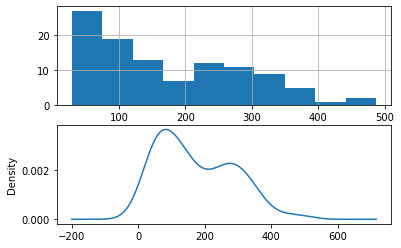

In [18]:
# density plots of time series
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Some observations from the plots include:
* The distribution is not Gaussian.
* The distribution is left shifted and may be exponential or a double Gaussian.
* Modellemeden önce verilerin bazı güç dönüşümlerini keşfetmede bazı faydalar görebiliriz.    

## Box and Whisker Plots
Aylık verileri yıllara göre gruplandırabilir ve her yıl için gözlemlerin yayılması ve bunun nasıl değişebileceği hakkında fikir edinebiliriz. Biraz eğilim görmeyi bekliyoruz (artan ortalama veya medyan), ancak dağılımın geri kalanının nasıl değiştiğini görmek ilginç olabilir. Aşağıdaki örnek, gözlemleri yıla göre gruplandırır ve her gözlem yılı için bir kutu ve bıyık grafiği oluşturur. Geçen yıl (1974) sadece 10 ay içerir ve diğer yıllardaki diğer 12 aylık gözlemlerle yararlı bir karşılaştırma olmayabilir. Bu nedenle, sadece 1966 ile 1973 arasındaki veriler çizildi.

0
1966-01-01     41
1966-02-01     39
1966-03-01     50
1966-04-01     40
1966-05-01     43
             ... 
1974-06-01    287
1974-07-01    355
1974-08-01    460
1974-09-01    364
1974-10-01    487
Name: 1, Length: 106, dtype: int64


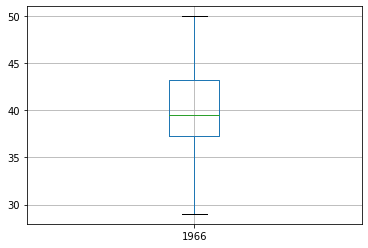

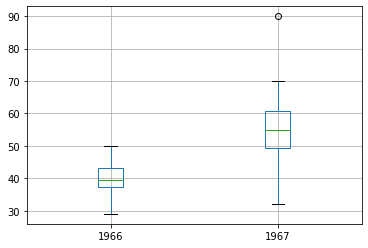

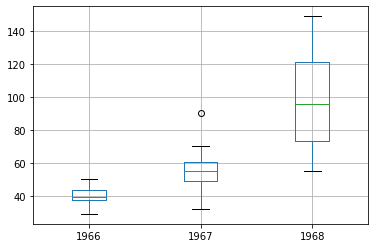

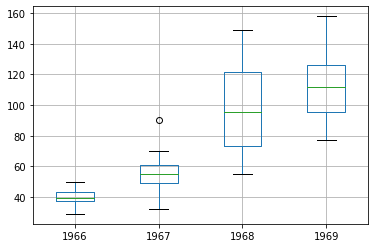

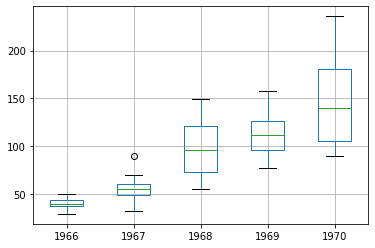

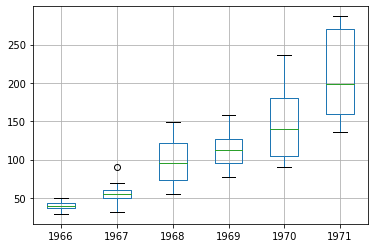

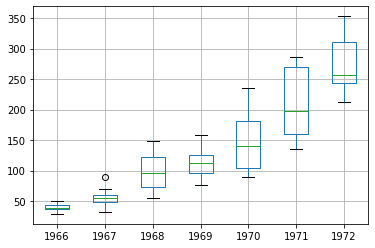

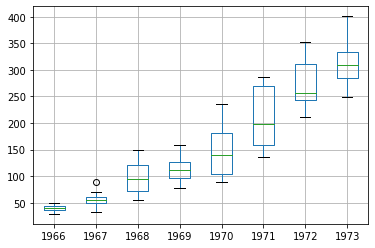

In [22]:
# boxplots of time series
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
print(series)
groups = series['1966':'1973'].groupby(Grouper(freq='A')) 
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
    years.boxplot()
    pyplot.show()

Daha önceki yıllar, belki de ilk 2, veri kümesinin geri kalanından oldukça farklıdır. bu yüzden bu iki yılı çıkartmak mantıklı olabilir

## ARIMA Models

Bu bölümde, sorun için Otoregresif Entegre Hareketli Ortalama veya ARIMA modelleri geliştireceğiz. Buna dört adımda yaklaşacağız:
1. Elle yapılandırılmış bir ARIMA modeli geliştirme.
2. Optimize edilmiş bir model bulmak için ARIMA'nın Grid Search kullanma
3. Modeldeki herhangi bir yanlılığı değerlendirmek için tahmini kalan hataların analizi
4. Güç dönüşümlerini kullanarak modeldeki geliştirmeleri keşfedin.

## Manually Configured ARIMA
Mevsimsel olmayan ARIMA (p, d, q) üç parametre gerektirir ve geleneksel olarak manuel olarak yapılandırılır. Zaman serisi verilerinin analizi, sabit bir zaman serisi ile çalıştığımızı varsayar. Zaman serileri neredeyse hiç durağan değil. İlk önce serileri farklılaştırarak ve sonucun sabit olduğunu doğrulamak için istatistiksel bir test kullanarak durağan hale getirebiliriz. Aşağıdaki örnek, serinin sabit bir sürümünü oluşturur ve bunu stationary.csv dosyasına kaydederiz.

In [24]:
# statistical test for the stationarity of the time series
from pandas import read_csv
from pandas import Series
from statsmodels.tsa.stattools import adfuller
# create a differenced time series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


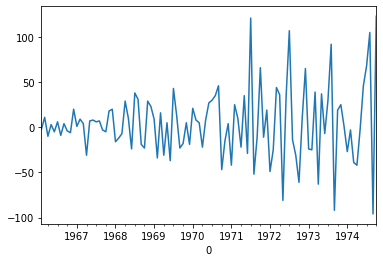

In [25]:
stationary.plot()

Sıfır hipotezinin reddedilmesi, işlemin birim kökü olmadığı ve buna karşılık 1 gecikmeli farklı zaman serilerinin sabit veya zamana bağlı bir yapıya sahip olmadığı anlamına gelir.


Bu, en az bir fark seviyesinin gerekli olduğunu göstermektedir. ARIMA modelimizdeki d parametresi en az 1 değeri olmalıdır. Bir sonraki adım sırasıyla OtoRegresyon (AR) ve Hareketli Ortalama (MA) parametreleri, p ve q için gecikme değerlerini seçmektir. Bunu, Otokorelasyon Fonksiyonu (ACF) ve Kısmi Otokorelasyon Fonksiyonu (PACF) grafiklerini inceleyerek yapabiliriz. Aşağıdaki örnek, seri için ACF ve PACF grafikleri oluşturur.

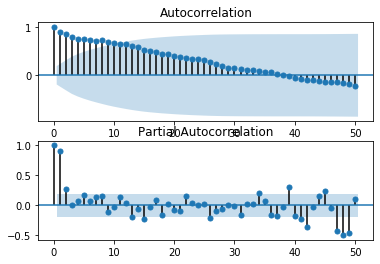

In [27]:
# ACF and PACF plots of time series
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=50, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=50, ax=pyplot.gca())
pyplot.show()

Örneği çalıştırın ve ARIMA modeli için p ve q değişkenlerinin nasıl ayarlanacağına dair bilgiler için grafikleri inceleyin.

Some observations from the plots:
* ACF 10-11 ay boyunca önemli bir gecikme gösterir.
* PACF, belki de 2 ay boyunca önemli bir gecikme gösterir.
* Hem ACF hem de PACF aynı noktada bir düşüş gösterir, belki de AR ve MA'nın bir karışımını gösterir.
* P ve q değerleri için iyi bir başlangıç ​​noktası 11 ve 2'dir

Bu hızlı analiz, ham veriler üzerindeki bir ARIMA'nın (11,1,2) iyi bir başlangıç ​​noktası olabileceğini düşündürmektedir. Deneyler, ARIMA'nın bu yapılandırmasının, benzer büyük AR değerlerinde olduğu gibi, temel kütüphane tarafından yakınsamadığını ve hatalarla sonuçlandığını göstermektedir. Bazı deneyler, modelin aynı anda tanımlanmayan sıfır olmayan AR ve MA siparişleri ile kararlı görünmediğini göstermektedir. Model ARIMA (0,1,2) ile basitleştirilebilir. Aşağıdaki örnek, bu ARIMA modelinin test kemeri üzerindeki performansını gösterir.

In [30]:
# evaluate manually configured ARIMA model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)


>Predicted=102.710, Expected=125.000
>Predicted=118.868, Expected=155.000
>Predicted=141.099, Expected=190.000
>Predicted=176.593, Expected=236.000
>Predicted=233.418, Expected=189.000
>Predicted=186.905, Expected=174.000
>Predicted=184.846, Expected=178.000
>Predicted=183.763, Expected=136.000
>Predicted=146.180, Expected=161.000
>Predicted=171.279, Expected=171.000
>Predicted=170.196, Expected=149.000
>Predicted=154.425, Expected=184.000
>Predicted=185.707, Expected=155.000
>Predicted=157.284, Expected=276.000
>Predicted=245.280, Expected=224.000
>Predicted=222.242, Expected=213.000
>Predicted=219.698, Expected=279.000
>Predicted=261.506, Expected=268.000
>Predicted=264.287, Expected=287.000
>Predicted=282.759, Expected=238.000
>Predicted=255.843, Expected=213.000
>Predicted=235.189, Expected=257.000
>Predicted=257.622, Expected=293.000
>Predicted=280.345, Expected=212.000
>Predicted=235.564, Expected=246.000
>Predicted=255.342, Expected=353.000
>Predicted=318.613, Expected=339.000
>

## Grid Search ARIMA Hyperparameters
Birçok ARIMA yapılandırması bu veri kümesinde kararsızdır, ancak iyi performans gösteren bir modelle sonuçlanan başka hiper parametreler olabilir. Bu bölümde, hata ile sonuçlanmayan kombinasyonlar için p, d ve q değerlerini arayacağız ve en iyi performansla sonuçlanan kombinasyonu bulacağız. Tamsayı değerlerin bir alt kümesindeki tüm kombinasyonları keşfetmek için bir ızgara araması kullanacağız. Özellikle, aşağıdaki parametrelerin tüm kombinasyonlarını arayacağız:
* p: 0to12
* d: 0 to 3
* q: 0to12

In [1]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order): # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

## Review Residual Errors
Bir modelin iyi bir son kontrolü, kalan tahmin hatalarını gözden geçirmektir. İdeal olarak, artık hataların dağılımı sıfır ortalamaya sahip bir Gauss olmalıdır. Kalıntıları bir histogram ve yoğunluk grafikleri ile çizerek bunu kontrol edebiliriz. Aşağıdaki örnek, test setindeki tahminler için kalan hataları hesaplar ve bu yoğunluk grafiklerini oluşturur.

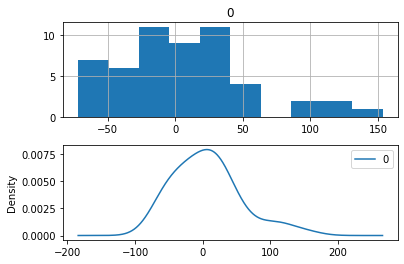

In [4]:
# plot residual errors for ARIMA model
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
  # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca()) 
pyplot.subplot(212) 
residuals.plot(kind='kde', ax=pyplot.gca()) 
pyplot.show()

Örneği çalıştırmak iki grafiği oluşturur. Grafikler, daha uzun sağ kuyruğu olan Gauss benzeri bir dağılım göstermektedir. Bu belki de tahminlerin önyargılı olduğunun ve bu durumda belki de modellemeden önce ham verilerin güç temelli dönüşümünün faydalı olabileceğinin bir işaretidir.

Her türlü otokorelasyon için kalan hataların zaman serilerini kontrol etmek de iyi bir fikirdir. Varsa, modelin verilerdeki zamansal yapıyı modellemek için daha fazla fırsata sahip olduğunu önerecektir. Aşağıdaki örnek, kalan hataları yeniden hesaplar ve herhangi bir önemli otokorelasyonu kontrol etmek için ACF ve PACF grafikleri oluşturur.

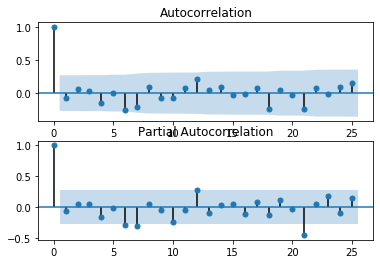

In [5]:
# ACF and PACF plots of forecast residual errors
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
  # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, lags=25, ax=pyplot.gca())
pyplot.show()

Sonuçlar, zaman serisinde ne kadar az otokorelasyonun model tarafından yakalandığını göstermektedir.

## Box-Cox Transformed Dataset
Box-Cox dönüşümü, bunlarla sınırlı olmamakla birlikte, verilerin günlük, karekök ve karşılıklı dönüşümlerini içeren bir dizi güç dönüşümü değerlendirebilen bir yöntemdir. Aşağıdaki örnek, verilerin bir günlük dönüşümünü gerçekleştirir ve zaman serileri üzerindeki etkiyi gözden geçirmek için bazı grafikler oluşturur.

Lambda: 0.260060


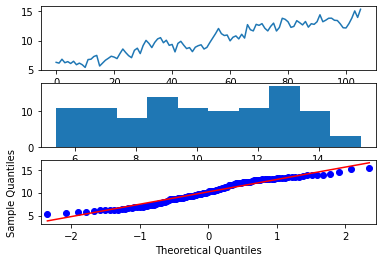

In [2]:
# plots of box-cox transformed dataset
from pandas import read_csv
from scipy.stats import boxcox
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca()) 
pyplot.show()

* Bu grafiklerden bazı gözlemler aşağıdadır:
* The large fluctuations have been removed from the line plot of the time series.
􏰀* The histogram shows a flatter or more uniform (well behaved) distribution of values. 􏰀 
* The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Kuşkusuz, Box-Cox dönüşümü zaman serilerine bir şeyler yaptı ve faydalı olabilir. ARIMA modelini dönüştürülmüş verilerle test etmeye devam etmeden önce, dönüştürülmüş veriler üzerinde eğitilmiş bir modelle yapılan tahminleri orijinal ölçeğe dönüştürmek için dönüşümü tersine çevirmenin bir yolunu bulmalıyız. Örnekte kullanılan boxcox () işlevi, bir maliyet işlevini optimize ederek ideal bir lambda değeri bulur. Lambda aşağıdakilerde kullanılır

In [3]:
# invert Box-Cox transform
from math import log
from math import exp
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

ARIMA (0,1,2) modelini Box-Cox dönüşümü ile yeniden değerlendirebiliriz. Bu, önce ARIMA modelini takmadan önce tarihin dönüştürülmesini, daha sonra beklenen değerlerle daha sonra karşılaştırılmak üzere saklanmadan önce dönüşümü tahmin üzerine ters çevirmeyi içerir. Boxcox () işlevi başarısız olabilir. Pratikte, bunu gördüm ve -5'ten daha düşük bir döndürülen lambda değeri ile işaret edildiği görülüyor. Geleneksel olarak lambda değerleri -5 ile 5 arasında değerlendirilir.

-5'ten düşük bir lambda değeri için bir kontrol eklenir ve bu durumda 1 değerinde bir lambda değeri varsayılır ve modele uyması için ham geçmiş kullanılır. 1 lambda değeri, dönüşüm yok ile aynıdır ve bu nedenle ters dönüşümün bir etkisi yoktur. Tüm örnek aşağıda listelenmiştir.

In [6]:
# evaluate ARIMA models with box-cox transformed time series
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam) 
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)


>Predicted=104.062, Expected=125.000
>Predicted=119.209, Expected=155.000
>Predicted=138.905, Expected=190.000
>Predicted=166.139, Expected=236.000
>Predicted=205.906, Expected=189.000
>Predicted=183.612, Expected=174.000
>Predicted=184.410, Expected=178.000
>Predicted=186.637, Expected=136.000
>Predicted=154.261, Expected=161.000
>Predicted=175.660, Expected=171.000
>Predicted=174.170, Expected=149.000
>Predicted=159.916, Expected=184.000
>Predicted=187.302, Expected=155.000
>Predicted=161.653, Expected=276.000


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


>Predicted=244.354, Expected=224.000
>Predicted=212.416, Expected=213.000
>Predicted=221.180, Expected=279.000
>Predicted=262.629, Expected=268.000
>Predicted=260.125, Expected=287.000
>Predicted=283.321, Expected=238.000
>Predicted=255.089, Expected=213.000
>Predicted=241.698, Expected=257.000
>Predicted=267.302, Expected=293.000
>Predicted=286.367, Expected=212.000
>Predicted=237.879, Expected=246.000
>Predicted=265.181, Expected=353.000
>Predicted=323.319, Expected=339.000
>Predicted=318.585, Expected=308.000
>Predicted=315.823, Expected=247.000
>Predicted=279.552, Expected=257.000
>Predicted=289.121, Expected=322.000
>Predicted=323.735, Expected=298.000
>Predicted=305.189, Expected=273.000
>Predicted=297.090, Expected=312.000
>Predicted=322.523, Expected=249.000
>Predicted=275.872, Expected=286.000
>Predicted=307.548, Expected=279.000
>Predicted=291.949, Expected=309.000
>Predicted=315.578, Expected=401.000
>Predicted=369.483, Expected=309.000
>Predicted=316.868, Expected=328.000
>

## Model Validation
Modeller geliştirildikten ve bir son model seçildikten sonra, onaylanmalı ve sonlandırılmalıdır. Doğrulama, sürecin isteğe bağlı bir parçasıdır, ancak kendimize kandırılmadığımızı veya yalan söylemediğimizden emin olmak için son bir kontrol sağlayan bir bölümdür. Bu bölüm aşağıdaki adımları içerir:
* Finalize Model: Train and save the final model.
* Make Prediction: Load the finalized model and make a prediction.
* Validate Model: Load and validate the final model.

## Finalize Model
Modelin sonlandırılması, bir ARIMA modelinin tüm veri kümesine, bu durumda tüm veri kümesinin dönüştürülmüş bir sürümüne yerleştirilmesini içerir. Uygun olduğunda, model daha sonra kullanılmak üzere dosyaya kaydedilebilir. Veriler üzerinde bir Box-Cox dönüşümü de gerçekleştirildiğinden, seçilen lambda'yı bilmemiz gerekir, böylece modelden gelen herhangi bir tahmin orijinal, dönüştürülmemiş ölçeğe geri dönüştürülebilir. Aşağıdaki örnek, Box-Cox dönüşüm veri kümesinde bir ARIMA (0,1,2) modeline uyar ve tüm uygun nesneyi ve lambda değerini dosyaya kaydeder.

In [7]:
# finalize model and save to file with workaround
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2)) 
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl') 
numpy.save('model_lambda.npy', [lam])

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


## Make Prediction
Doğal bir durum, modeli yüklemek ve tek bir tahmin yapmak olabilir. Bu nispeten basittir ve kaydedilen modelin ve lambda'nın geri yüklenmesini ve tahmini () işlevinin çağrılmasını içerir. Aşağıdaki örnek modeli yükler, bir sonraki zaman adımı için bir tahmin yapar, Box-Cox dönüşümünü tersine çevirir ve tahmini yazdırır.

In [9]:
# load the finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
model_fit = ARIMAResults.load('model.pkl') 
lam = numpy.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
print('Predicted: %.3f' % yhat)


Predicted: 452.039


## Modeli Doğrula


>Predicted=452.039, Expected=452.000
>Predicted=423.097, Expected=391.000
>Predicted=408.373, Expected=500.000
>Predicted=482.451, Expected=451.000
>Predicted=445.937, Expected=375.000
>Predicted=413.894, Expected=372.000
>Predicted=413.210, Expected=302.000
>Predicted=355.157, Expected=316.000
>Predicted=363.514, Expected=398.000
>Predicted=406.362, Expected=394.000
>Predicted=394.186, Expected=431.000
>Predicted=428.175, Expected=431.000
RMSE: 53.079


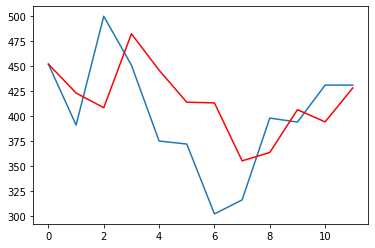

In [11]:
# evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) 
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True,
squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(0,1,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions)) 
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red') 
pyplot.show()
